In [1]:
#!pip install seaborn

In [2]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import scipy 
import tqdm
import maxent
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sns.set_context('paper')
sns.set_style('whitegrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
#plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
%matplotlib inline

## Set-up Prior Distribution

In [3]:
x = np.array([1., 1.])
i = tf.keras.Input((1,))
l = maxent.TrainableInputLayer(x)(i)
d = tfp.layers.DistributionLambda(lambda x: tfd.Normal(loc=x[...,0], scale=tf.math.exp(x[...,1])))(l)
model = maxent.ParameterJoint([lambda x: x], inputs=i, outputs=[d])
model.compile(tf.keras.optimizers.Adam(0.1))
model.summary()
model(tf.constant([1.]))

Model: "parameter_joint"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
trainable_input_layer (Train (None, 2)                 2         
_________________________________________________________________
distribution_lambda (Distrib ((None,), (None,))        0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


<tfp.distributions.Normal 'parameter_joint_distribution_lambda_Normal' batch_shape=[1] event_shape=[] dtype=float32>

## Simulator

In [4]:
def simulate(x):
    y = np.random.normal(loc=x, scale=0.1)
    return y
plt.figure()
unbiased_params = model.sample(100000)
y = simulate(*unbiased_params)
y = np.squeeze(y)

<Figure size 432x288 with 0 Axes>

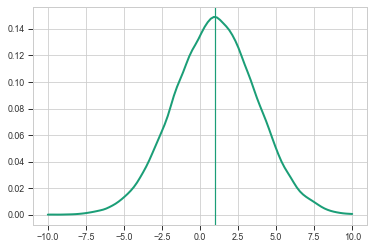

In [5]:
pdf = scipy.stats.gaussian_kde(y)
x = np.linspace(-10, 10, 100)
plt.plot(x, pdf.pdf(x), color=colors[0], linewidth=2)
plt.axvline(np.mean(y), color=colors[0])

## Maximum Entropy Method

In [6]:
r = maxent.Restraint(lambda x: x, 4, maxent.EmptyPrior())

me_model = maxent.MaxentModel([r])
me_model.compile(tf.keras.optimizers.Adam(0.01), 'mean_squared_error')
result = me_model.fit(y, epochs=4, batch_size=128)

Epoch 1/4
782/782 [==============================] - 0s 389us/step - loss: 0.5052 - weight-entropy: 4.3072
Epoch 2/4
782/782 [==============================] - 0s 376us/step - loss: 0.3230 - weight-entropy: 4.2823
Epoch 3/4
782/782 [==============================] - 0s 379us/step - loss: 0.3546 - weight-entropy: 4.2877
Epoch 4/4
782/782 [==============================] - 0s 376us/step - loss: 0.3512 - weight-entropy: 4.2864


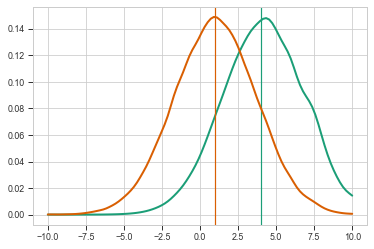

In [7]:
plt.axvline(x=4, color=colors[0])
wpdf = scipy.stats.gaussian_kde(np.squeeze(y), weights=np.squeeze(me_model.traj_weights))
x = np.linspace(-10, 10, 100)
plt.plot(x, wpdf.pdf(x), color=colors[0], linewidth=2)


plt.plot(x, pdf.pdf(x), color=colors[1], linewidth=2)
plt.axvline(np.mean(np.squeeze(y)), color=colors[1])

## Variational MaxEnt

Try to fit to more extreme value - 10

In [8]:
r = maxent.Restraint(lambda x: x, 10, maxent.EmptyPrior())
hme_model = maxent.HyperMaxentModel([r], model, simulate)
hme_model.compile(tf.keras.optimizers.SGD(0.005), 'mean_squared_error')
result = hme_model.fit(epochs=4, sample_batch_size=len(y) // 4)


Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 80.7914 - weight-entropy: 10.1267
Epoch 2/4
1/1 [==============================] - 0s 1ms/step - loss: 19.3688 - weight-entropy: 8.6481
Epoch 3/4
1/1 [==============================] - 0s 1ms/step - loss: 7.6213 - weight-entropy: 7.3457
Epoch 4/4
1/1 [==============================] - 0s 1ms/step - loss: 4.3377 - weight-entropy: 6.6618
Epoch 1/4
782/782 [==============================] - 0s 425us/step - loss: 0.0030
Epoch 2/4
782/782 [==============================] - 0s 417us/step - loss: 0.0030
Epoch 3/4
782/782 [==============================] - 0s 412us/step - loss: 0.0028
Epoch 4/4
782/782 [==============================] - 0s 427us/step - loss: 0.0029
Epoch 1/4
1/1 [==============================] - 0s 1ms/step - loss: 3.0630e-07 - weight-entropy: 9.5349
Epoch 2/4
1/1 [==============================] - 0s 1ms/step - loss: 3.1346e-09 - weight-entropy: 9.5352
Epoch 3/4
1/1 [==============================] - 0s 1ms/

In [9]:
w2pdf = scipy.stats.gaussian_kde(np.squeeze(hme_model.trajs), weights=np.squeeze(hme_model.traj_weights))

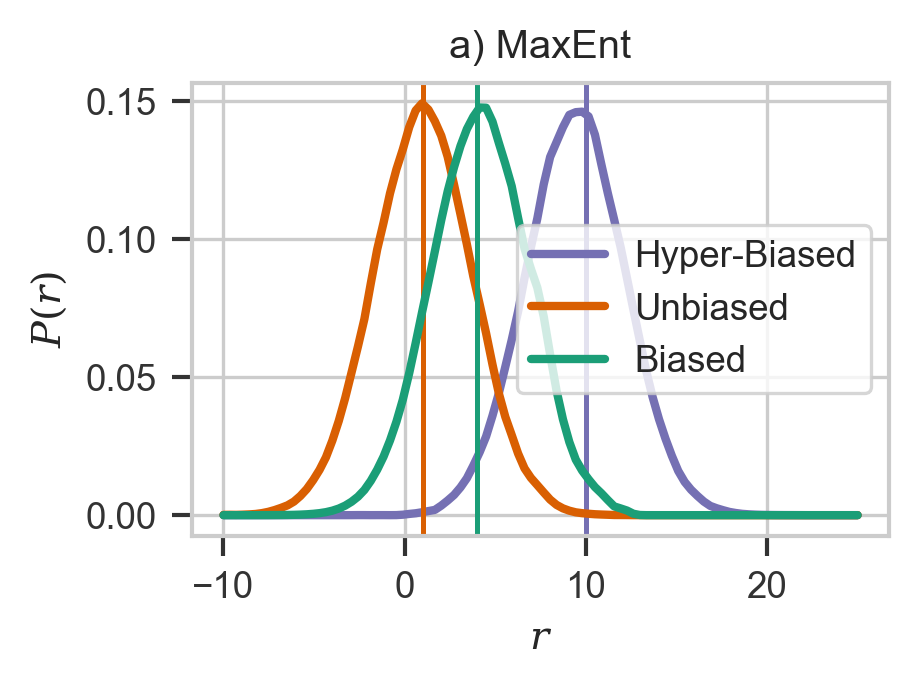

In [10]:
plt.figure(figsize=(3,2), dpi=300)
x = np.linspace(-10, 25, 100)
plt.plot(x, w2pdf.pdf(x), color=colors[2], linewidth=2, label='Hyper-Biased')
plt.axvline(x=10, color=colors[2])

plt.plot(x, pdf.pdf(x), color=colors[1], linewidth=2, label='Unbiased')
plt.axvline(np.mean(np.squeeze(y)), color=colors[1])

plt.plot(x, wpdf.pdf(x), color=colors[0], linewidth=2, label='Biased')
plt.axvline(x=4, color=colors[0])
plt.xlabel(r'$r$')
plt.ylabel(r'$P(r)$')
plt.title('a) MaxEnt')
plt.legend()
plt.savefig('maxent.svg')


## Bayesian Inference Setting

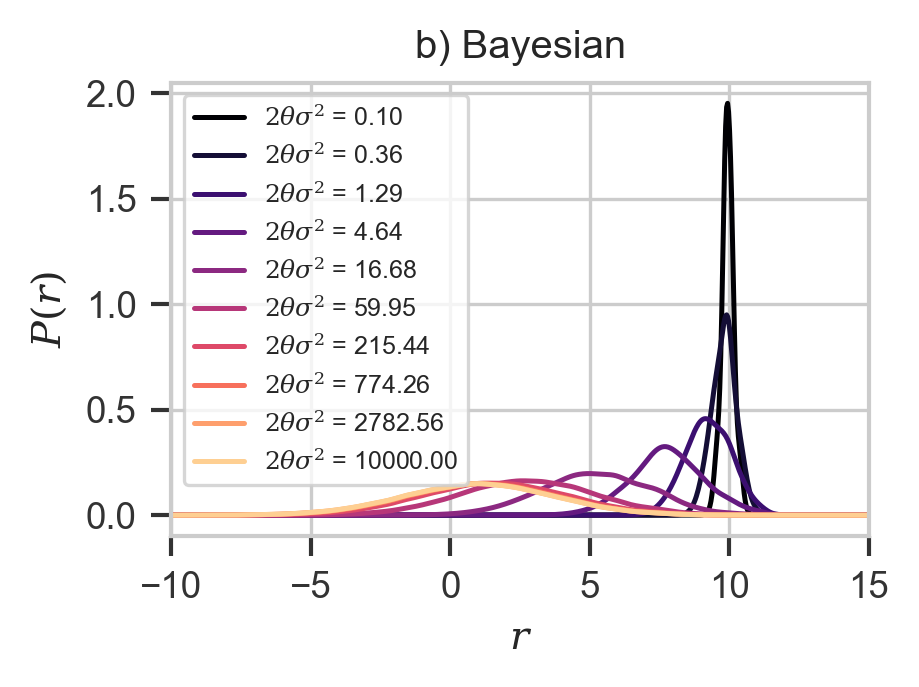

In [11]:
# https://pubmed.ncbi.nlm.nih.gov/26723635/
plt.figure(figsize=(3,2), dpi=300)
x = np.linspace(-10, 25, 1000)
cmap = plt.get_cmap('magma')
prior = 10**np.linspace(-1, 4, 10)
bpdf = np.exp(-(y - 10)**2 / prior[:, np.newaxis])
bpdf /= np.sum(bpdf, axis=1)[:, np.newaxis]
for i,p in enumerate(prior):
    ppdf = scipy.stats.gaussian_kde(np.squeeze(y), weights=bpdf[i])    
    plt.plot(x, ppdf.pdf(x), color=cmap(i / len(prior)), label=f'$2\\theta\\sigma^2$ = {p:.2f}')
plt.legend(fontsize=6)
plt.xlim(-10, 15)
plt.xlabel(r'$r$')
plt.ylabel(r'$P(r)$')
plt.title('b) Bayesian')
plt.savefig('bayes.svg')
plt.show()

## Effects of Observable

In [12]:
bayesian_results = []
#scipy.stats.wasserstein_distance(y, y, u_weights=np.ones_like(y) / len(y), v_weights=bpdf[i])])
x2 = np.linspace(-20, 20, 10000)
for i in range(len(prior)):
    ppdf = scipy.stats.gaussian_kde(np.squeeze(y), weights=bpdf[i])    
    bayesian_results.append([np.sum(ppdf.pdf(x) * x * (x[1] - x[0])),  
          -np.nansum((x[1] - x[0]) * ppdf.pdf(x) * np.log(ppdf.pdf(x)))])
    print(i, bayesian_results[-1])

c:\users\white\maxent\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
c:\users\white\maxent\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


0 [9.94581421519621, -0.06412079705195209]
1 [9.81049293756406, 0.6308702963567875]
2 [9.263196198980195, 1.2495692016761912]
3 [7.801062135805839, 1.7046509941414203]
4 [5.219484950324088, 2.1060679639674924]
5 [2.7796016404317205, 2.311024307622988]
6 [1.584448720111317, 2.3879762775878994]
7 [1.1770182130253661, 2.4122082666694284]
8 [1.0563919401669875, 2.4192008967639897]
9 [1.0222260080084704, 2.4211660421830397]


In [ ]:
me_results = []
for i in range(-5, 10):
    r = maxent.Restraint(lambda x: x, i, maxent.EmptyPrior())
    m = maxent.MaxentModel([r])
    m.compile(tf.keras.optimizers.Adam(0.001), 'mean_squared_error')
    m.fit(y, epochs=4, batch_size=256)    
    #d = scipy.stats.wasserstein_distance(y, y, u_weights=m.traj_weights)
    ppdf = scipy.stats.gaussian_kde(y, weights=m.traj_weights)    
    d=  -np.nansum((x[1] - x[0]) * ppdf.pdf(x) * np.log(ppdf.pdf(x)))
    me_results.append([i, d])
    print(np.sum(y * m.traj_weights), d)

Epoch 1/4
391/391 [==============================] - 0s 387us/step - loss: 22.5769 - weight-entropy: 5.3897
Epoch 2/4
391/391 [==============================] - 0s 376us/step - loss: 7.2419 - weight-entropy: 4.7338
Epoch 3/4
391/391 [==============================] - 0s 376us/step - loss: 3.0059 - weight-entropy: 4.1123
Epoch 4/4
391/391 [==============================] - 0s 376us/step - loss: 2.0160 - weight-entropy: 3.7501
-4.8069906 2.308571284601972
Epoch 1/4
391/391 [==============================] - 0s 391us/step - loss: 14.3021 - weight-entropy: 5.3940
Epoch 2/4
391/391 [==============================] - 0s 378us/step - loss: 3.5362 - weight-entropy: 4.8129
Epoch 3/4
391/391 [==============================] - 0s 374us/step - loss: 1.3904 - weight-entropy: 4.3532
Epoch 4/4
391/391 [==============================] - 0s 383us/step - loss: 1.1043 - weight-entropy: 4.1544
-3.871349 2.3718350679686244
Epoch 1/4
391/391 [==============================] - 0s 448us/step - loss: 8.0142 - 

In [ ]:
plt.figure(figsize=(3,2), dpi=300)
me_result = np.array(me_results)
bayesian_results = np.array(bayesian_results)
plt.plot(me_result[:, 0], me_result[:,1], label='MaxEnt', color=colors[0])
plt.plot(bayesian_results[:,0], bayesian_results[:,1], linestyle='--', label='Bayesian Inference', color=colors[1])
plt.ylabel('Posterior Entropy')
plt.xlabel('$E[r]$')
plt.legend()
plt.title('c) Posterior Entropy')
plt.savefig('post.svg')
plt.show()


In [ ]:
bayesian_results[:]